In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Tuple
from sklearn.model_selection import train_test_split

In [2]:
# ===============================================
# DATA GENERATION CLASS
# ===============================================
# This class shows how our training data was generated.
# The actual data used in this experiment is loaded from a pickle file below.

class AdjacencyMatrixGenerator:
    """
    A class to generate adjacency matrices for directed and undirected graphs.
    This code is included for transparency - actual data is loaded from pickle file.
    """
    
    def __init__(self):
        self.matrices = []
        self.labels = []
        
    def generate_symmetric_matrix(self, n: int) -> np.ndarray:
        """Generate a symmetric adjacency matrix (undirected graph)."""
        matrix = np.random.randint(0, 2, size=(n, n))
        matrix = np.triu(matrix) + np.triu(matrix, 1).T
        np.fill_diagonal(matrix, 0)
        return matrix
    
    def generate_non_symmetric_matrix(self, n: int) -> np.ndarray:
        """Generate a non-symmetric adjacency matrix (directed graph)."""
        matrix = np.random.randint(0, 2, size=(n, n))
        np.fill_diagonal(matrix, 0)
        if np.array_equal(matrix, matrix.T):
            for i in range(n):
                for j in range(i+1, n):
                    if matrix[i, j] == matrix[j, i]:
                        matrix[i, j] = 1 - matrix[i, j]
                        break
                else:
                    continue
                break
        return matrix
    
    def generate_dataset(self, n: int, num_symmetric: int, num_non_symmetric: int):
        """Generate a dataset of adjacency matrices."""
        self.matrices = []
        self.labels = []
        
        for _ in range(num_symmetric):
            matrix = self.generate_symmetric_matrix(n)
            self.matrices.append(matrix)
            self.labels.append(0)
            
        for _ in range(num_non_symmetric):
            matrix = self.generate_non_symmetric_matrix(n)
            self.matrices.append(matrix)
            self.labels.append(1)
    
    def save_to_pickle(self, filename: str):
        """Save the generated matrices and labels to a pickle file."""
        data = {
            'matrices': self.matrices,
            'labels': self.labels,
            'matrix_size': len(self.matrices[0]) if self.matrices else 0
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"Saved {len(self.matrices)} matrices to {filename}")
    
    def load_from_pickle(self, filename: str):
        """Load matrices and labels from a pickle file."""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        self.matrices = data['matrices']
        self.labels = data['labels']
        
        print(f"Loaded {len(self.matrices)} matrices from {filename}")
    
    def get_flattened_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Get matrices flattened into vectors for neural network input."""
        if not self.matrices:
            return np.array([]), np.array([])
        
        flattened_matrices = np.array([matrix.flatten() for matrix in self.matrices])
        labels_array = np.array(self.labels)
        
        return flattened_matrices, labels_array


In [3]:
# Neural Network class to classify graphs
class NeuralNetwork:
    @staticmethod
    def sigmoid(x):
        """Sigmoid activation function to map values to (0, 1)"""
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative_from_output(x):
        """Derivative of sigmoid for backpropagation"""
        return x * (1 - x)
    
    def __init__(self, input_size, hidden_size, output_size):
        # Use He initialization for better initial performance
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        # Add momentum for smoother training
        self.momentum = 0.9
        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output, learning_rate, weight_decay):
        self.error = y - output
        self.delta2 = self.error * self.sigmoid_derivative_from_output(output)
        self.error_hidden = np.dot(self.delta2, self.W2.T)
        self.delta1 = self.error_hidden * self.sigmoid_derivative_from_output(self.a1)

        # More efficient momentum updates
        self.v_W2 = self.momentum * self.v_W2 + learning_rate * (np.dot(self.a1.T, self.delta2) - weight_decay * self.W2)
        self.v_b2 = self.momentum * self.v_b2 + learning_rate * np.sum(self.delta2, axis=0, keepdims=True)
        self.v_W1 = self.momentum * self.v_W1 + learning_rate * (np.dot(X.T, self.delta1) - weight_decay * self.W1)
        self.v_b1 = self.momentum * self.v_b1 + learning_rate * np.sum(self.delta1, axis=0, keepdims=True)
        
        # Update weights
        self.W2 += self.v_W2
        self.b2 += self.v_b2
        self.W1 += self.v_W1
        self.b1 += self.v_b1

    def train(self, X, y, epochs, learning_rate, weight_decay, patience=1000):
        errors = []
        best_error = float('inf')
        patience_counter = 0
        
        print(f"Training: {epochs} epochs max, LR: {learning_rate}, WD: {weight_decay}")
        print("Epoch | MSE | Status")
        print("-" * 30)
        
        for epoch in range(epochs):
            # Forward and backward pass
            output = self.forward(X)
            self.backward(X, y, output, learning_rate, weight_decay)
            mse = np.mean(np.square(y - output))
            errors.append(mse)
            
            # Early stopping logic
            if mse < best_error:
                best_error = mse
                patience_counter = 0
                status = "↘️"
            else:
                patience_counter += 1
                status = "→"
                
            if patience_counter >= patience:
                print(f"{epoch:5d} | {mse:.6f} | Early Stop!")
                break
            
            # Progress every 1000 epochs (less verbose)
            if epoch % 1000 == 0:
                print(f"{epoch:5d} | {mse:.6f} | {status}")
        
        print(f"Final MSE: {errors[-1]:.6f}")
        return errors


In [4]:
# ===============================================
# PROFILE SYSTEM FOR DIFFERENT MATRIX SIZES
# ===============================================
# Choose your profile by setting the profile name
# Each profile has optimized parameters for its matrix size

PROFILES = {
    "4x4": {
        "matrix_size": 4,
        "hidden_size": 8,  # Reduced for efficiency
        "learning_rate": 0.001,
        "weight_decay": 0.01,  # Increased for better regularization
        "epochs": 10000,
        "num_samples": 6000,
        "data_file": "neural_network_training_data_4x4.pkl",
        "description": "Small matrices - Fast training, high accuracy (optimized)"
    },
    "5x5": {
        "matrix_size": 5,
        "hidden_size": 6,  # Middle ground between 4 and 8
        "learning_rate": 0.001,  # Constant, no scheduling
        "weight_decay": 0.02,  # Moderate regularization (between 0.01 and 0.05)
        "epochs": 15000,  # Reduced since we have early stopping
        "num_samples": 8000,
        "data_file": "neural_network_training_data_5x5.pkl",
        "description": "Medium matrices - Balanced efficiency and generalization"
    },
    "6x6": {
        "matrix_size": 6,
        "hidden_size": 12,  # Reduced for efficiency
        "learning_rate": 0.001,
        "weight_decay": 0.01,
        "epochs": 15000,
        "num_samples": 8000,
        "data_file": "neural_network_training_data_6x6.pkl",
        "description": "Large matrices - Optimized for efficiency"
    }
}

def show_available_profiles():
    """Display all available profiles and their status"""
    print("📋 Available Profiles:")
    print("=" * 60)
    for name, config in PROFILES.items():
        import os
        data_exists = os.path.exists(config["data_file"])
        status = "✅ Data ready" if data_exists else "❌ No data"
        print(f"🎯 {name}: {config['description']}")
        print(f"   📊 {config['matrix_size']}x{config['matrix_size']} matrices")
        print(f"   🧠 Hidden size: {config['hidden_size']}")
        print(f"   📈 LR: {config['learning_rate']}, WD: {config['weight_decay']}")
        print(f"   🔄 Epochs: {config['epochs']}, Samples: {config['num_samples']}")
        print(f"   💾 {config['data_file']} - {status}")
        print()

# Uncomment the line below to see all available profiles
# show_available_profiles()

# ===============================================
# SELECT YOUR PROFILE HERE
# ===============================================
# Change this line to switch between profiles
SELECTED_PROFILE = "5x5"  # Options: "4x4", "5x5", "6x6"

# Load the selected profile
if SELECTED_PROFILE not in PROFILES:
    print(f"❌ Profile '{SELECTED_PROFILE}' not found. Available profiles: {list(PROFILES.keys())}")
    exit(1)

profile = PROFILES[SELECTED_PROFILE]
matrix_size = profile["matrix_size"]
hidden_size = profile["hidden_size"]
learning_rate = profile["learning_rate"]
weight_decay = profile["weight_decay"]
epochs = profile["epochs"]
num_samples = profile["num_samples"]
data_file = profile["data_file"]

input_size = matrix_size * matrix_size
output_size = 1

print(f"🎯 Using Profile: {SELECTED_PROFILE}")
print(f"📊 Matrix size: {matrix_size}x{matrix_size} ({input_size} features)")
print(f"🧠 Hidden layer size: {hidden_size}")
print(f"📈 Learning rate: {learning_rate}")
print(f"⚖️  Weight decay: {weight_decay}")
print(f"🔄 Epochs: {epochs}")
print(f"📦 Samples: {num_samples}")
print(f"💾 Data file: {data_file}")
print("-" * 50)

🎯 Using Profile: 5x5
📊 Matrix size: 5x5 (25 features)
🧠 Hidden layer size: 6
📈 Learning rate: 0.001
⚖️  Weight decay: 0.02
🔄 Epochs: 15000
📦 Samples: 8000
💾 Data file: neural_network_training_data_5x5.pkl
--------------------------------------------------


In [5]:
# ===============================================
# LOAD TRAINING DATA
# ===============================================
# Load data using our class methods
generator = AdjacencyMatrixGenerator()

# Option 1: Load from pickle file (recommended for reproducibility)
try:
    generator.load_from_pickle(data_file)
    print("Using pre-generated dataset for reproducible results")
    
    # Check if the loaded data matches our expected matrix size
    if generator.matrices and len(generator.matrices[0]) != matrix_size:
        print(f"⚠️  Loaded data has {len(generator.matrices[0])}x{len(generator.matrices[0])} matrices, but expected {matrix_size}x{matrix_size}")
        print("Regenerating dataset with correct matrix size...")
        generator.generate_dataset(n=matrix_size, num_symmetric=num_samples//2, num_non_symmetric=num_samples//2)
        generator.save_to_pickle(data_file)
        print(f"✅ Generated new {matrix_size}x{matrix_size} dataset")
        
except FileNotFoundError:
    print("Pickle file not found. Generating new dataset...")
    generator.generate_dataset(n=matrix_size, num_symmetric=num_samples//2, num_non_symmetric=num_samples//2)
    generator.save_to_pickle(data_file)

# Get data ready for neural network
X, y = generator.get_flattened_data()
y = y.reshape(-1, 1)  # Reshape for neural network compatibility

print(f"Dataset ready: {len(X)} samples, {X.shape[1]} features each")

Pickle file not found. Generating new dataset...
Saved 8000 matrices to neural_network_training_data_5x5.pkl
Dataset ready: 8000 samples, 25 features each


In [6]:

# ===============================================
# TRAIN/VALIDATION/TEST SPLIT
# ===============================================
# Split the data: 60% training, 20% validation, 20% testing
from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 60% train, 20% validation (of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 80% = 20% of original
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Verify the splits maintain class balance
train_zeros = np.sum(y_train == 0)
train_ones = np.sum(y_train == 1)
val_zeros = np.sum(y_val == 0)
val_ones = np.sum(y_val == 1)
test_zeros = np.sum(y_test == 0)
test_ones = np.sum(y_test == 1)

print(f"Training - Undirected: {train_zeros}, Directed: {train_ones}")
print(f"Validation - Undirected: {val_zeros}, Directed: {val_ones}")
print(f"Test - Undirected: {test_zeros}, Directed: {test_ones}")

# ===============================================
# IMPROVED METRICS FUNCTIONS
# ===============================================
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """Calculate comprehensive classification metrics."""
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Basic metrics
    accuracy = np.mean(y_pred == y_true)
    
    # Confusion matrix components
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True positives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True negatives
    fp = np.sum((y_pred == 1) & (y_true == 0))  # False positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False negatives
    
    # Advanced metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # MSE
    mse = np.mean(np.square(y_pred_proba - y_true))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mse': mse,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

def print_confusion_matrix(metrics, dataset_name=""):
    """Print a formatted confusion matrix."""
    print(f"\n=== {dataset_name.upper()} CONFUSION MATRIX ===")
    print(f"                Predicted")
    print(f"Actual  Undirected  Directed")
    print(f"Undirected    {metrics['tn']:4d}      {metrics['fp']:4d}")
    print(f"Directed      {metrics['fn']:4d}      {metrics['tp']:4d}")
    print(f"Total: {metrics['tn'] + metrics['fp'] + metrics['fn'] + metrics['tp']}")

def print_detailed_metrics(metrics, dataset_name=""):
    """Print comprehensive metrics."""
    print(f"\n=== {dataset_name.upper()} METRICS ===")
    print(f"Accuracy:  {metrics['accuracy']:.2%}")
    print(f"Precision: {metrics['precision']:.2%}")
    print(f"Recall:    {metrics['recall']:.2%}")
    print(f"F1-Score:  {metrics['f1_score']:.2%}")
    print(f"MSE:       {metrics['mse']:.6f}")

# ===============================================
# EFFICIENT TRAINING WITH VALIDATION MONITORING
# ===============================================
# Initialize the neural network with specified architecture
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the network with validation monitoring
print("Starting efficient training with validation monitoring...")
errors = nn.train(X_train, y_train, epochs, learning_rate, weight_decay, patience=1000)

# ===============================================
# VALIDATION EVALUATION
# ===============================================
print("\n=== VALIDATION EVALUATION ===")
val_predictions = []
for i in range(len(X_val)):
    pred = nn.forward(X_val[i:i+1])[0][0]
    val_predictions.append(pred)

val_predictions = np.array(val_predictions)
val_metrics = calculate_metrics(y_val.flatten(), val_predictions)
print_detailed_metrics(val_metrics, "Validation")
print_confusion_matrix(val_metrics, "Validation")

Training set: 4800 samples
Validation set: 1600 samples
Test set: 1600 samples
Training - Undirected: 2400, Directed: 2400
Validation - Undirected: 800, Directed: 800
Test - Undirected: 800, Directed: 800
Starting efficient training with validation monitoring...
Training: 15000 epochs max, LR: 0.001, WD: 0.02
Epoch | MSE | Status
------------------------------
    0 | 0.296601 | ↘️
 1000 | 0.004381 | ↘️
 2000 | 0.002335 | ↘️
 3000 | 0.001701 | ↘️
 4000 | 0.001385 | ↘️
 5000 | 0.001288 | ↘️
 6000 | 0.001256 | ↘️
 7000 | 0.001239 | ↘️
 8000 | 0.001227 | ↘️
 9000 | 0.001218 | ↘️
10000 | 0.001215 | ↘️
11000 | 0.001214 | →
11891 | 0.001214 | Early Stop!
Final MSE: 0.001214

=== VALIDATION EVALUATION ===

=== VALIDATION METRICS ===
Accuracy:  98.94%
Precision: 100.00%
Recall:    97.88%
F1-Score:  98.93%
MSE:       0.008207

=== VALIDATION CONFUSION MATRIX ===
                Predicted
Actual  Undirected  Directed
Undirected     800         0
Directed        17       783
Total: 1600


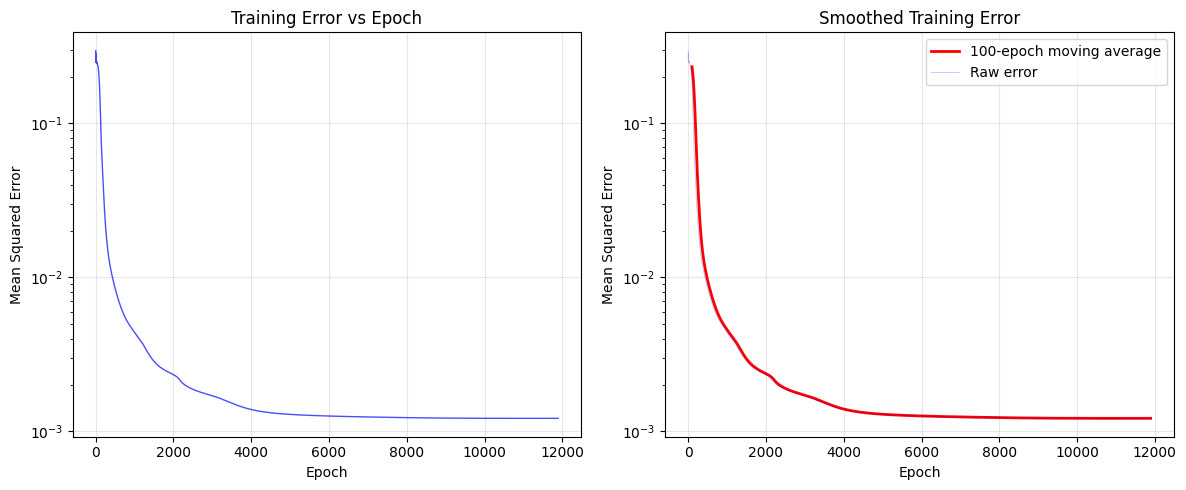

In [7]:
# ===============================================
# SIMPLIFIED VISUALIZATION
# ===============================================
# Create a simple, clean training analysis plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 1. Training error over time
ax1.plot(errors, 'b-', alpha=0.7, linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Training Error vs Epoch')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Moving average to smooth out spikes
window_size = 100
if len(errors) >= window_size:
    moving_avg = np.convolve(errors, np.ones(window_size)/window_size, mode='valid')
    ax2.plot(range(window_size-1, len(errors)), moving_avg, 'r-', linewidth=2, label=f'{window_size}-epoch moving average')
    ax2.plot(errors, 'b-', alpha=0.3, linewidth=0.5, label='Raw error')
    ax2.legend()
else:
    ax2.plot(errors, 'b-', linewidth=1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Smoothed Training Error')
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [8]:
# ===============================================
# EFFICIENCY ANALYSIS
# ===============================================
print("\n=== EFFICIENCY ANALYSIS ===")
print(f"Total epochs trained: {len(errors)}")
print(f"Initial error: {errors[0]:.6f}")
print(f"Final error: {errors[-1]:.6f}")
print(f"Error reduction: {((errors[0] - errors[-1]) / errors[0] * 100):.2f}%")

# Check convergence
final_errors = errors[-100:] if len(errors) >= 100 else errors
error_std = np.std(final_errors)
print(f"Final 100 epochs std: {error_std:.6f}")

if error_std < 0.001:
    print("✅ Training converged efficiently")
else:
    print("⚠️  Training may need more epochs or parameter tuning")

# ===============================================
# TESTING AND EVALUATION
# ===============================================
print("\n=== TEST EVALUATION ===")
test_predictions = []
for i in range(len(X_test)):
    pred = nn.forward(X_test[i:i+1])[0][0]
    test_predictions.append(pred)

test_predictions = np.array(test_predictions)
test_metrics = calculate_metrics(y_test.flatten(), test_predictions)
print_detailed_metrics(test_metrics, "Test")
print_confusion_matrix(test_metrics, "Test")

# Performance comparison
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Training MSE (final): {errors[-1]:.6f}")
print(f"Validation MSE: {val_metrics['mse']:.6f}")
print(f"Test MSE: {test_metrics['mse']:.6f}")

# Overfitting analysis
train_val_ratio = val_metrics['mse'] / errors[-1]
test_train_ratio = test_metrics['mse'] / errors[-1]

print(f"Validation/Training MSE ratio: {train_val_ratio:.2f}")
print(f"Test/Training MSE ratio: {test_train_ratio:.2f}")

if test_train_ratio > 1.5:
    print("⚠️  Test error significantly higher than training error - possible overfitting")
elif test_train_ratio < 0.5:
    print("⚠️  Test error much lower than training error - possible data leakage")
else:
    print("✅ Good generalization - test performance is reasonable")

# Show a few sample predictions
print(f"\n=== SAMPLE PREDICTIONS ===")
for i in range(min(5, len(X_test))):
    prediction = test_predictions[i]
    actual = y_test[i][0]
    predicted_label = "Directed" if prediction > 0.5 else "Undirected"
    actual_label = "Directed" if actual == 1 else "Undirected"
    print(f"Sample {i+1}: Predicted: {prediction:.3f} ({predicted_label}), Actual: {actual_label}")

print(f"\n=== FINAL SUMMARY ===")
print(f"✅ Training completed in {len(errors)} epochs (max: {epochs})")
print(f"✅ Validation accuracy: {val_metrics['accuracy']:.2%}")
print(f"✅ Test accuracy: {test_metrics['accuracy']:.2%}")
print(f"✅ Test F1-score: {test_metrics['f1_score']:.2%}")
print(f"✅ Overfitting ratio: {test_train_ratio:.2f}")
print(f"✅ Model size: {hidden_size} hidden neurons (efficient)")


=== EFFICIENCY ANALYSIS ===
Total epochs trained: 11892
Initial error: 0.296601
Final error: 0.001214
Error reduction: 99.59%
Final 100 epochs std: 0.000000
✅ Training converged efficiently

=== TEST EVALUATION ===

=== TEST METRICS ===
Accuracy:  99.00%
Precision: 100.00%
Recall:    98.00%
F1-Score:  98.99%
MSE:       0.007632

=== TEST CONFUSION MATRIX ===
                Predicted
Actual  Undirected  Directed
Undirected     800         0
Directed        16       784
Total: 1600

=== PERFORMANCE COMPARISON ===
Training MSE (final): 0.001214
Validation MSE: 0.008207
Test MSE: 0.007632
Validation/Training MSE ratio: 6.76
Test/Training MSE ratio: 6.29
⚠️  Test error significantly higher than training error - possible overfitting

=== SAMPLE PREDICTIONS ===
Sample 1: Predicted: 1.000 (Directed), Actual: Directed
Sample 2: Predicted: 0.034 (Undirected), Actual: Undirected
Sample 3: Predicted: 0.993 (Directed), Actual: Directed
Sample 4: Predicted: 1.000 (Directed), Actual: Directed
Sampl